In [1]:
%load_ext zipline


After you installed zipline you should be able to execute the following from your command line (e.g. cmd.exe on Windows, or the Terminal app on OSX):

In [3]:
!zipline run --help

Usage: zipline run [OPTIONS]

  Run a backtest for the given algorithm.

Options:
  -f, --algofile FILENAME         The file that contains the algorithm to run.
  -t, --algotext TEXT             The algorithm script to run.
  -D, --define TEXT               Define a name to be bound in the namespace
                                  before executing the algotext. For example
                                  '-Dname=value'. The value may be any python
                                  expression. These are evaluated in order so
                                  they may refer to previously defined names.

  --data-frequency [minute|daily]
                                  The data frequency of the simulation.
                                  [default: daily]

  --capital-base FLOAT            The starting capital for the simulation.
                                  [default: 10000000.0]

  -b, --bundle BUNDLE-NAME        The data bundle to use for the simulation.
                    

# Breakdown of the attributes of context
![Title](img/context.png)

1. order_target_percent
函数形式：order_target_percent(asset, target, limit_price=None, stop_price=None, style=None)
函数说明：按指定比例，为指定资产下单
2. order_target
函数形式：order_target(asset, target, limit_price=None, stop_price=None, style=None)
函数说明：按指定数额，为指定资产下单
3. record
函数形式：record(*args, **kwargs)
函数说明：跟踪、记录每天产生的值
4. symbol
函数形式：symbol(symbol_str)
函数说明：根据股票代码，查到股票。不是实时更新股票信息的变更。

In [4]:
%%zipline --start 2015-1-1 --end 2021-02-27 --capital-base 10000 --bundle custom-bundle -o perf_ipython.pickle


import talib
from zipline.api import order_target, record, symbol, order_target_percent, set_benchmark


# Setup our variables
def initialize(context):
    
    # what stock to trade - FAANG in this example
    # stocklist = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
    stocklist = ['SPY', 'ARKK', 'VNQ', 'VNQI']
    set_benchmark(symbol('SPY'))

    # make a list of symbols for the list of tickers
    context.stocks = [symbol(s) for s in stocklist]
    
    # create equal weights of each stock to hold in our portfolio
    context.target_pct_per_stock = 1.0 / len(context.stocks)
    
    # create initial RSI threshold values for low (oversold and buy signal) and high (overbought and sell signal)
    context.LOW_RSI = 30
    context.HIGH_RSI = 70

# Rebalance daily.
def handle_data(context, data):
    
    # Load historical pricing data for the stocks, using daily frequncy and a rolling 20 days
    prices = data.history(context.stocks, 'price', bar_count=20, frequency="1d")
    
    rsis = {}
    # print(prices)
    # Loop through our list of stocks
    for stock in context.stocks:
        # Get the rsi of this stock.
        # print(prices[stock])
        rsi = talib.RSI(prices[stock].values, timeperiod=14)[-1]
        rsis[stock] = rsi
        
        current_position = context.portfolio.positions[stock].amount
        
        # RSI is above 70 and we own shares, time to sell
        if rsi > context.HIGH_RSI and current_position > 0 and data.can_trade(stock):
            order_target(stock, 0)
   
        # RSI is below 30 and we don't have any shares, time to buy
        elif rsi < context.LOW_RSI and current_position == 0 and data.can_trade(stock):
            order_target_percent(stock, context.target_pct_per_stock)

    # record the current RSI values of each stock for later ispection
    record(spy_rsi=rsis[symbol('SPY')],
           arkk_rsi=rsis[symbol('ARKK')],
           vnq_rsi=rsis[symbol('VNQ')],
           vnqi_rsi=rsis[symbol('VNQI')])


,algo_volatility,algorithm_period_return,alpha,arkk_rsi,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,sortino,spy_rsi,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,vnq_rsi,vnqi_rsi
2015-01-02 21:00:00+00:00,NaN,0.000000,NaN,50.336238,-0.000536,NaN,NaN,0.0,10000.00000,0.00,...,NaN,46.473068,10000.00000,0.00,0.00,1,[],0.0,60.037820,43.259707
2015-01-05 21:00:00+00:00,0.000000,0.000000,0.000000,41.532002,-0.018584,0.196683,0.000000,0.0,10000.00000,0.00,...,NaN,38.764047,10000.00000,0.00,0.00,2,[],0.0,64.261644,39.689344
2015-01-06 21:00:00+00:00,0.000000,0.000000,0.000000,45.456311,-0.027832,0.139080,0.000000,0.0,10000.00000,0.00,...,NaN,37.929951,10000.00000,0.00,0.00,3,[],0.0,66.315754,42.928572
2015-01-07 21:00:00+00:00,0.000000,0.000000,0.000000,47.473922,-0.015718,0.206968,0.000000,0.0,10000.00000,0.00,...,NaN,45.016184,10000.00000,0.00,0.00,4,[],0.0,69.990841,51.533794
2015-01-08 21:00:00+00:00,0.000000,0.000000,0.000000,56.211122,0.001750,0.236053,0.000000,0.0,10000.00000,0.00,...,NaN,56.970832,10000.00000,0.00,0.00,5,[],0.0,71.196887,57.127401
2015-01-09 21:00:00+00:00,0.000000,0.000000,0.000000,52.780610,-0.006279,0.218123,0.000000,0.0,10000.00000,0.00,...,NaN,52.259655,10000.00000,0.00,0.00,6,[],0.0,70.206814,57.126566
2015-01-12 21:00:00+00:00,0.000000,0.000000,0.000000,57.615381,-0.014061,0.203329,0.000000,0.0,10000.00000,0.00,...,NaN,53.805996,10000.00000,0.00,0.00,7,[],0.0,75.535769,60.352167
2015-01-13 21:00:00+00:00,0.000000,0.000000,0.000000,58.582396,-0.016834,0.188309,0.000000,0.0,10000.00000,0.00,...,NaN,54.692171,10000.00000,0.00,0.00,8,[],0.0,80.333329,70.857201
2015-01-14 21:00:00+00:00,0.000000,0.000000,0.000000,62.023774,-0.022768,0.177399,0.000000,0.0,10000.00000,0.00,...,NaN,54.331926,10000.00000,0.00,0.00,9,[],0.0,82.459744,72.203182
2015-01-15 21:00:00+00:00,0.000000,0.000000,0.000000,50.851596,-0.031721,0.170564,0.000000,0.0,10000.00000,0.00,...,NaN,44.587304,10000.00000,0.00,0.00,10,[],0.0,79.888635,69.548157


In [58]:
import pickle
import pandas as pd
import numpy as np
import pyfolio as pf
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() # Setting seaborn as default style even if use only matplotlib


In [59]:
df = pd.read_pickle('./perf_ipython.pickle')
df.columns
df.prediction.value_counts()

[1]    1113
[0]     352
Name: prediction, dtype: int64

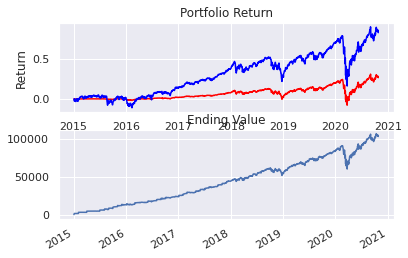

In [60]:
fig, ax = plt.subplots(2,1)
sns.lineplot(ax=ax[0], x=df.index, y=df['algorithm_period_return'], color ='red' )
sns.lineplot(ax=ax[0], x=df.index, y=df['benchmark_period_return'], color ='blue')

ax[0].set(xlabel='Year', ylabel='Return')

ax[0].set_title('Portfolio Return')

ax[1].set_title('Ending Value')
df.ending_value.plot(ax=ax[1])



In [38]:
%%zipline --start 2015-1-1 --end 2020-10-26 --capital-base 10000 --bundle custom-bundle -o perf_ipython.pickle


import talib
from zipline.api import order_target, record, symbol, order_target_percent, set_benchmark


# Setup our variables
def initialize(context):
    
    # what stock to trade - FAANG in this example
    # stocklist = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
    stocklist = ['SPY']
    set_benchmark(symbol('SPY'))

    # make a list of symbols for the list of tickers
    context.stocks = [symbol(s) for s in stocklist]
    
    # create equal weights of each stock to hold in our portfolio
    context.target_pct_per_stock = 1.0 / len(context.stocks)
    
    # create initial RSI threshold values for low (oversold and buy signal) and high (overbought and sell signal)
    context.LOW_RSI = 30
    context.HIGH_RSI = 70

# Rebalance daily.
def handle_data(context, data):
    
    # Load historical pricing data for the stocks, using daily frequncy and a rolling 20 days
    prices = data.history(context.stocks, 'price', bar_count=20, frequency="1d")
    
    rsis = {}
    # print(prices)
    # Loop through our list of stocks
    for stock in context.stocks:
        # Get the rsi of this stock.
        # print(prices[stock])
        rsi = talib.RSI(prices[stock].values, timeperiod=14)[-1]
        rsis[stock] = rsi
        
        current_position = context.portfolio.positions[stock].amount
        
        # RSI is above 70 and we own shares, time to sell
        if rsi > context.HIGH_RSI and current_position > 0 and data.can_trade(stock):
            order_target(stock, 0)
   
        # RSI is below 30 and we don't have any shares, time to buy
        elif rsi < context.LOW_RSI and current_position == 0 and data.can_trade(stock):
            order_target_percent(stock, context.target_pct_per_stock)


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,NaN,0.000000,NaN,-0.000534,NaN,NaN,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,1,[],0.0
2015-01-05 21:00:00+00:00,0.000000,0.000000,0.000000,-0.018582,0.196704,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,2,[],0.0
2015-01-06 21:00:00+00:00,0.000000,0.000000,0.000000,-0.027829,0.139096,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,3,[],0.0
2015-01-07 21:00:00+00:00,0.000000,0.000000,0.000000,-0.015712,0.206987,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,4,[],0.0
2015-01-08 21:00:00+00:00,0.000000,0.000000,0.000000,0.001754,0.236041,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,5,[],0.0
2015-01-09 21:00:00+00:00,0.000000,0.000000,0.000000,-0.006274,0.218112,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,6,[],0.0
2015-01-12 21:00:00+00:00,0.000000,0.000000,0.000000,-0.014061,0.203327,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,7,[],0.0
2015-01-13 21:00:00+00:00,0.000000,0.000000,0.000000,-0.016833,0.188306,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,8,[],0.0
2015-01-14 21:00:00+00:00,0.000000,0.000000,0.000000,-0.022769,0.177398,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,9,[],0.0
2015-01-15 21:00:00+00:00,0.000000,0.000000,0.000000,-0.031723,0.170563,0.000000,0.0,10000.000000,0.0,0.0,...,0.0,0.0,0,NaN,10000.000000,0.0,0.0,10,[],0.0


In [4]:
%%zipline --start 2015-1-1 --end 2020-10-26 --capital-base 10000 --bundle custom-bundle -o perf_ipython.pickle

from zipline.api import order, record, order_target_percent, symbol, schedule_function, date_rules, time_rules

# rebalance strategy

#%%
def initialize(context):
    # ETFs and target weights for a balanced and hedged portfolio
    context.securities = {
        'VTI': 0.43, 
        'TLT': 0.04, 
        'VEU': 0.13, 
        'VWO': 0.13, 
        'VNQ': 0.08,
        'VNQI': 0.05,
        'QQQ': 0.15
    }
    
    # Schedule rebalance for once a month
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())
    
    # Set up a benchmark to measure against
    context.set_benchmark(symbol('SPY'))


def rebalance(context, data):
    # Loop through the securities
    for sec, weight in context.securities.items():
        sym = symbol(sec)
        
        # Check if we can trade
        if data.can_trade(sym):
            # Reset the weight
            order_target_percent(sym, weight) 


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,NaN,0.000000,NaN,-0.000534,NaN,NaN,0.000000,10000.000000,0.00,0.00,...,0.0,0.0,0,NaN,10000.000000,0.00,0.00,1,[],0.0
2015-01-05 21:00:00+00:00,0.005580,-0.000497,0.003823,-0.018582,0.196704,0.028369,-9679.621325,320.378675,9674.65,9674.65,...,0.0,0.0,0,-11.224972,10000.000000,0.00,0.00,2,"[{'amount': 40, 'dt': 2015-01-05 21:00:00+00:0...",0.0
2015-01-06 21:00:00+00:00,0.057259,-0.006975,-0.400634,-0.027829,0.139096,0.031795,0.000000,320.378675,9609.87,9609.87,...,0.0,0.0,0,-9.839249,320.378675,9674.65,9674.65,3,[],0.0
2015-01-07 21:00:00+00:00,0.129030,0.005761,1.344661,-0.015712,0.206987,0.495314,0.000000,320.378675,9737.23,9737.23,...,0.0,0.0,0,7.139708,320.378675,9609.87,9609.87,4,[],0.0
2015-01-08 21:00:00+00:00,0.142321,0.019718,1.544413,0.001754,0.236041,0.528599,0.000000,320.378675,9876.80,9876.80,...,0.0,0.0,0,21.541854,320.378675,9737.23,9737.23,5,[],0.0
2015-01-09 21:00:00+00:00,0.140524,0.014375,1.106504,-0.006274,0.218112,0.563795,0.000000,320.378675,9823.37,9823.37,...,0.0,0.0,0,11.243128,320.378675,9876.80,9876.80,6,[],0.0
2015-01-12 21:00:00+00:00,0.136473,0.008950,0.852902,-0.014061,0.203327,0.587060,0.000000,320.378675,9769.12,9769.12,...,0.0,0.0,0,5.528728,320.378675,9823.37,9823.37,7,[],0.0
2015-01-13 21:00:00+00:00,0.126376,0.009798,0.855236,-0.016833,0.188306,0.587029,0.000000,320.378675,9777.60,9777.60,...,0.0,0.0,0,5.647405,320.378675,9769.12,9769.12,8,[],0.0
2015-01-14 21:00:00+00:00,0.120252,0.006851,0.769997,-0.022769,0.177398,0.593506,0.000000,320.378675,9748.13,9748.13,...,0.0,0.0,0,3.613650,320.378675,9777.60,9777.60,9,[],0.0
2015-01-15 21:00:00+00:00,0.115786,0.002926,0.743676,-0.031723,0.170563,0.597713,0.000000,320.378675,9708.88,9708.88,...,0.0,0.0,0,1.436095,320.378675,9748.13,9748.13,10,[],0.0


In [95]:
%%zipline --start 2015-1-1 --end 2020-10-26 --capital-base 100000 --bundle custom-bundle -o monthly_investment.pickle

from zipline.api import order, record, order_target_percent, symbol, schedule_function, date_rules, time_rules

from zipline.api import order, record, symbol
from zipline.finance import commission, slippage

# monthly investment

def initialize(context):
    context.asset = symbol('VTI')

    context.monthy_invest_amt = 1500
    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_benchmark(symbol('VTI'))
    # Schedule rebalance for once a month
    schedule_function(monthly_avg, date_rules.month_end(), time_rules.market_open())


def monthly_avg(context, data):
    # load price history 
    # price [0] = 1 day
    price = data.history(context.asset, 'price', bar_count=1, frequency="1d")
    quantity = 1500/price[0]
    order(context.asset, quantity )

    


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,NaN,0.000000,NaN,-0.000758,NaN,NaN,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,1,[],0.0
2015-01-05 21:00:00+00:00,0.000000,0.000000,0.000000,-0.017928,0.184371,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,2,[],0.0
2015-01-06 21:00:00+00:00,0.000000,0.000000,0.000000,-0.027550,0.130590,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,3,[],0.0
2015-01-07 21:00:00+00:00,0.000000,0.000000,0.000000,-0.015938,0.199120,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,4,[],0.0
2015-01-08 21:00:00+00:00,0.000000,0.000000,0.000000,0.001411,0.230666,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,5,[],0.0
2015-01-09 21:00:00+00:00,0.000000,0.000000,0.000000,-0.006885,0.213794,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,6,[],0.0
2015-01-12 21:00:00+00:00,0.000000,0.000000,0.000000,-0.013959,0.198512,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,7,[],0.0
2015-01-13 21:00:00+00:00,0.000000,0.000000,0.000000,-0.016223,0.183797,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,8,[],0.0
2015-01-14 21:00:00+00:00,0.000000,0.000000,0.000000,-0.021602,0.172912,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,9,[],0.0
2015-01-15 21:00:00+00:00,0.000000,0.000000,0.000000,-0.031508,0.167606,0.000000,0.00000,100000.00000,0.00,0.00,...,0.0,0.0,0,NaN,100000.00000,0.00,0.00,10,[],0.0


In [90]:
%%zipline --start 2015-1-1 --end 2020-10-26 --capital-base 100000 --bundle custom-bundle -o ML_approach.pickle

#monthly investmnent strategy with machine learning

from zipline.api import order, record, order_target_percent, symbol, schedule_function, date_rules, time_rules
import pandas as pd
import numpy as np
import inspect
import datetime as dt

from zipline.api import order, record, symbol
from zipline.finance import commission, slippage
from sklearn.linear_model import LogisticRegression


def initialize(context):
    context.security = symbol('VTI')
    context.model = LogisticRegression()
    context.traded = 1 # 1 = already traded
    context.monthy_invest_amt = 1500
    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_benchmark(symbol('VTI'))
    # Schedule rebalance for once a month
    context.lookback = 3 # Look back 3 days
    context.history_range = 720 # Only consider the past 400 days' history
    context.predict_values = 0
    #the current date rules are week_start for create_model and week_end for trade.

    schedule_function(reset_trade, date_rules.month_start(), time_rules.market_open())

    # Generate a new model every week
    schedule_function(create_model, date_rules.month_start(), time_rules.market_open())

    # Trade at the start of every day
    schedule_function(trade_month_start, date_rules.month_start(), time_rules.market_open())

    schedule_function(trade_month_end, date_rules.month_end(), time_rules.market_open())

def reset_trade(context, data):
    context.traded = 0


def create_model(context, data):
    # Get the relevant daily prices
    recent_prices = data.history(context.security, 'price', bar_count=context.history_range, frequency="1d")
    # print(recent_prices)
    # print(recent_prices.index)
    # print(recent_prices.pct_change())

    # print(recent_prices.resample('BMS').first())
    # print(recent_prices.resample('BM').last())
    month_start = recent_prices.resample('BMS').first().to_frame(name='close').reset_index()
    month_start['year'] = month_start['index'].dt.year
    month_start['month'] = month_start['index'].dt.month
    month_end = recent_prices.resample('BM').last().to_frame(name='close').reset_index()
    month_end['year'] = month_end['index'].dt.year
    month_end['month'] = month_end['index'].dt.month
    # print(month_start.columns)
    combine = pd.merge(month_start, month_end, how='inner', on=['year','month'], suffixes=('_start','_end'))
    combine['monthly diff'] = combine['close_end'] - combine['close_start']
    combine['change'] = combine['monthly diff'].apply(lambda x: 1 if x > 0 else 0)

    # total 6 months to be include in the prediction
    month_incl = 12
    for i in range(month_incl):
        combine['delta_{}'.format(i+1)] = combine['change'].shift(i+1)

    combine.drop(['close_start',
    'year',
    #'month',
    'close_end',
    'monthly diff',
    'index_start',
    'index_end'], axis = 1, inplace=True)

    combine.drop(combine.tail(1).index, inplace=True)
    combine.dropna(inplace=True)

    # print(combine)
    # print(combine.columns)
    # Get the price changes
    # price_changes = np.diff(recent_prices).tolist()

    feature_cols = [col for col in combine.columns if 'change' not in col]

    # print(price_changes)
    X = [] # Independent, or input variables
    Y = [] # Dependent, or output variable


    X = combine[feature_cols].values
    Y = combine['change'].values


    
    # For each day in our history
    #
    # X.append(price_changes[0:2]) # Store prior price changes
    # Y.append(price_changes[-1]) # Store the day's price change
    # X = recent_prices[0:2])
    # Y = recent_prices[-1]
    # for i in range(context.lookback):
    #    X.append([recent_prices[0:2]])
    #    Y.append([recent_prices[-1]])
        
        # print(price_changes[0:2])
        # print(price_changes[-1])



    # for i in range(context.history_range-context.lookback-1):
    #    X.append(price_changes[i:i+context.lookback]) # Store prior price changes
    #    Y.append(price_changes[i+context.lookback]) # Store the day's price change
    # X = np.array(X).reshape(-1, 1)
    # print(X)
    # print(Y)
    context.model.fit(X, Y) # Generate our model

def is_fitted(model):
        """Checks if model object has any attributes ending with an underscore"""
        return 0 < len( [k for k,v in inspect.getmembers(model) if k.endswith('_') and not k.startswith('__')] )


def trade_month_start(context, data):
    if is_fitted(context.model) and context.traded == 0: # Check if our model is generated
            recent_prices = data.history(context.security, 'price', bar_count=context.history_range, frequency="1d")
            price = data.history(context.security, 'price', bar_count=1, frequency="1d")
            # print(recent_prices)
            # print(recent_prices.index)
            # print(recent_prices.pct_change())

            # print(recent_prices.resample('BMS').first())
            # print(recent_prices.resample('BM').last())
            month_start = recent_prices.resample('BMS').first().to_frame(name='close').reset_index()
            month_start['year'] = month_start['index'].dt.year
            month_start['month'] = month_start['index'].dt.month
            month_end = recent_prices.resample('BM').last().to_frame(name='close').reset_index()
            month_end['year'] = month_end['index'].dt.year
            month_end['month'] = month_end['index'].dt.month
            # print(month_start.columns)
            combine = pd.merge(month_start, month_end, how='inner', on=['year','month'], suffixes=('_start','_end'))
            combine['monthly diff'] = combine['close_end'] - combine['close_start']
            combine['change'] = combine['monthly diff'].apply(lambda x: 1 if x > 0 else 0)

            # total 6 months to be include in the prediction
            month_incl = 12
            for i in range(month_incl):
                combine['delta_{}'.format(i+1)] = combine['change'].shift(i+1)

            combine.drop(['close_start',
            'year',
            #'month',
            'close_end',
            'monthly diff',
            'change',
            'index_start',
            'index_end'], axis = 1, inplace=True)

            print(combine.tail(1).values)
            prediction = context.model.predict(combine.tail(1).values)
            context.predict_values = prediction[0]
            record(prediction = prediction)

            if context.predict_values  > 0 :
                quantity = 1500/price[0]
                order(context.security, quantity)
                print("{} : Trade {}, Prediction {}".format(price.index[0], quantity, context.predict_values))
                context.traded = 1


            # combine.drop(combine.tail(1).index, inplace=True)
            # combine.dropna(inplace=True)

def trade_month_end(context, data):
    if is_fitted(context.model) and context.traded == 0: # Check if our model is generated
            price = data.history(context.security, 'price', bar_count=1, frequency="1d")

            quantity = 1500/price[0]
            order(context.security, quantity)
            print("{} : Trade {}, Prediction {}".format(price.index[0], quantity, context.predict_values))

            context.traded = 1

            # combine.drop(combine.tail(1).index, inplace=True)
            # combine.dropna(inplace=True)
    


[[1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.]]
2015-01-02 00:00:00+00:00 : Trade 14.161631419939576, Prediction 1
[[2. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]]
2015-02-02 00:00:00+00:00 : Trade 14.387109150201418, Prediction 1
[[3. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.]]
2015-03-31 00:00:00+00:00 : Trade 13.986013986013987, Prediction 0
[[4. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.]]
2015-04-01 00:00:00+00:00 : Trade 14.012143858010276, Prediction 1
[[5. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1.]]
2015-05-29 00:00:00+00:00 : Trade 13.722440764797366, Prediction 0
[[6. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.]]
2015-06-30 00:00:00+00:00 : Trade 14.016071762287423, Prediction 0
[[7. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.]]
2015-07-01 00:00:00+00:00 : Trade 13.924990716672855, Prediction 1
[[8. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.]]
2015-08-03 00:00:00+00:00 : Trade 13.831258644536652, Prediction 1
[[9. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.]]
2015-09-01 00:00:00+00:00 : Trade 15.119443604475356, Prediction 1
[[10.  1. 

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,NaN,0.000000,NaN,-0.000758,NaN,NaN,0.00000,100000.000000,0.00,0.00,...,0.0,0.0,0,NaN,100000.000000,0.00,0.00,1,[],0.0
2015-01-05 21:00:00+00:00,0.000083,-0.000007,0.000086,-0.017928,0.184371,0.000452,-1458.14270,98541.857300,1457.40,1457.40,...,0.0,0.0,0,-11.224972,100000.000000,0.00,0.00,2,"[{'amount': 14, 'dt': 2015-01-05 21:00:00+00:0...",0.0
2015-01-06 21:00:00+00:00,0.001276,-0.000150,-0.010197,-0.027550,0.130590,0.001017,0.00000,98541.857300,1443.12,1443.12,...,0.0,0.0,0,-9.628812,98541.857300,1457.40,1457.40,3,[],0.0
2015-01-07 21:00:00+00:00,0.002049,0.000022,0.009166,-0.015938,0.199120,0.007775,0.00000,98541.857300,1460.34,1460.34,...,0.0,0.0,0,1.221045,98541.857300,1443.12,1443.12,4,[],0.0
2015-01-08 21:00:00+00:00,0.002520,0.000280,0.013302,0.001411,0.230666,0.009499,0.00000,98541.857300,1486.10,1486.10,...,0.0,0.0,0,13.881047,98541.857300,1460.34,1460.34,5,[],0.0
2015-01-09 21:00:00+00:00,0.002536,0.000156,0.009396,-0.006885,0.213794,0.010269,0.00000,98541.857300,1473.78,1473.78,...,0.0,0.0,0,5.371631,98541.857300,1486.10,1486.10,6,[],0.0
2015-01-12 21:00:00+00:00,0.002445,0.000051,0.007082,-0.013959,0.198512,0.010650,0.00000,98541.857300,1463.28,1463.28,...,0.0,0.0,0,1.429239,98541.857300,1473.78,1473.78,7,[],0.0
2015-01-13 21:00:00+00:00,0.002275,0.000018,0.005910,-0.016223,0.183797,0.010662,0.00000,98541.857300,1459.92,1459.92,...,0.0,0.0,0,0.458247,98541.857300,1463.28,1463.28,8,[],0.0
2015-01-14 21:00:00+00:00,0.002172,-0.000062,0.004735,-0.021602,0.172912,0.010809,0.00000,98541.857300,1451.94,1451.94,...,0.0,0.0,0,-1.408988,98541.857300,1459.92,1459.92,9,[],0.0
2015-01-15 21:00:00+00:00,0.002165,-0.000209,0.003621,-0.031508,0.167606,0.011201,0.00000,98541.857300,1437.24,1437.24,...,0.0,0.0,0,-3.811422,98541.857300,1451.94,1451.94,10,[],0.0


In [91]:
df1 = pd.read_pickle('ML_approach.pickle')
df2 = pd.read_pickle('monthly_investment.pickle')


drop_cols = [col for col in df1.columns if 'algorithm_period_return' not in col]
df1 = df1.drop(columns=drop_cols, axis=1).reset_index()
drop_cols = [col for col in df2.columns if 'algorithm_period_return' not in col]
df2 = df2.drop(columns=drop_cols, axis=1).reset_index()

combine = pd.merge(df1, df2, how='inner', on='index', suffixes=('_ML', '_normal'))


[Text(0, 0.5, 'Return'), Text(0.5, 0, 'Year')]

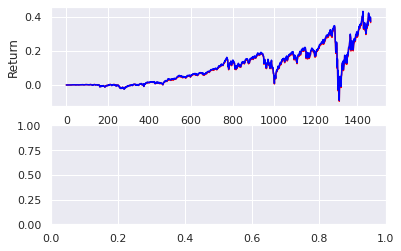

In [92]:
fig, ax = plt.subplots(2,1)
sns.lineplot(ax=ax[0], x=combine.index, y=combine['algorithm_period_return_ML'], color ='red' )
sns.lineplot(ax=ax[0], x=combine.index, y=combine['algorithm_period_return_normal'], color ='blue')

ax[0].set(xlabel='Year', ylabel='Return')


In [96]:
df1 = pd.read_pickle('ML_approach.pickle')
df1.to_excel('ML_backtest.xlsx')

df2 = pd.read_pickle('monthly_investment.pickle')
df2.to_excel('monthly_investment (month end).xlsx')